In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
import math
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from scipy.stats import uniform,norm
import matplotlib.pyplot as plt
import scipy.stats as sct
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.cluster import KMeans
from skimage import morphology
from skimage.draw import polygon

In [2]:
def read_structure(structure):
    contours = []
    for i in range(len(structure.ROIContourSequence)):
        if i == 3:
            contour = {}
            contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
            contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber ##
            contour['name'] = structure.StructureSetROISequence[i].ROIName
            contour['number'] == structure.StructureSetROISequence[i].ROINumber
            contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
            contours.append(contour)
    return contours

def get_mask(contours, slices):
    z = [round(s.ImagePositionPatient[2],1) for s in slices] ##
    #print(z)
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]

    label = np.zeros_like(image, dtype=np.uint8)
    for con in contours:
        num = int(con['number'])
        
        for c in con['contours']:
            nodes = np.array(c).reshape((-1, 3)) #triplets describing points of contour
            #assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
            z_index = z.index(np.around(nodes[0, 2], 1))
            #print(np.around(nodes[0, 2], 1))
            r = (nodes[:, 1] - pos_r) / spacing_r
            c = (nodes[:, 0] - pos_c) / spacing_c
            rr, cc = polygon(r, c)
            label[rr, cc, z_index] = num
            #con['color'] = [0, 0, 255] 
            colors = tuple(np.array([con['color'] for con in contours]) / 255.0)
    return label, colors

In [3]:
contour_path="C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/Prostate Cases/9/rtstruct/rtss.dcm"
img_path="C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/Prostate Cases/9/ct"

In [4]:
#read img and contour
contour=pydicom.read_file(contour_path)
contours=read_structure(contour)
slices = [pydicom.read_file(img_path + '/' + s) for s in os.listdir(img_path)]
image = np.stack([s.pixel_array for s in slices], axis=-1)
label, colors = get_mask(contours, slices)

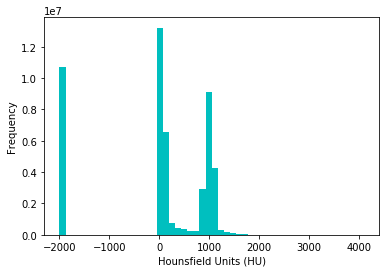

In [5]:
plt.hist(image.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [6]:
print("Slice Thickness: %f" % slices[8].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (slices[8].PixelSpacing[0], slices[8].PixelSpacing[1]))

Slice Thickness: 2.500000
Pixel Spacing (row, col): (0.976562, 0.976562) 


C:\Users\lykha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


(-0.5, 511.5, 511.5, -0.5)

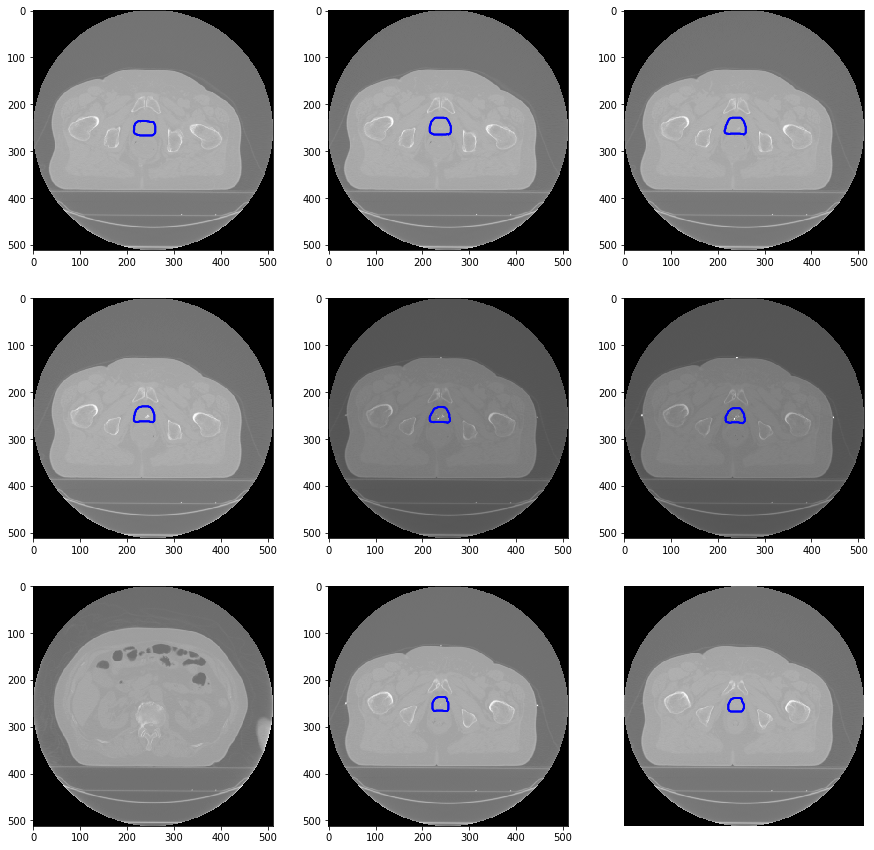

In [7]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[..., i  + 18 ], cmap="gray")
    plt.contour(label[..., i + 18 ], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.axis('off')

[0 4]


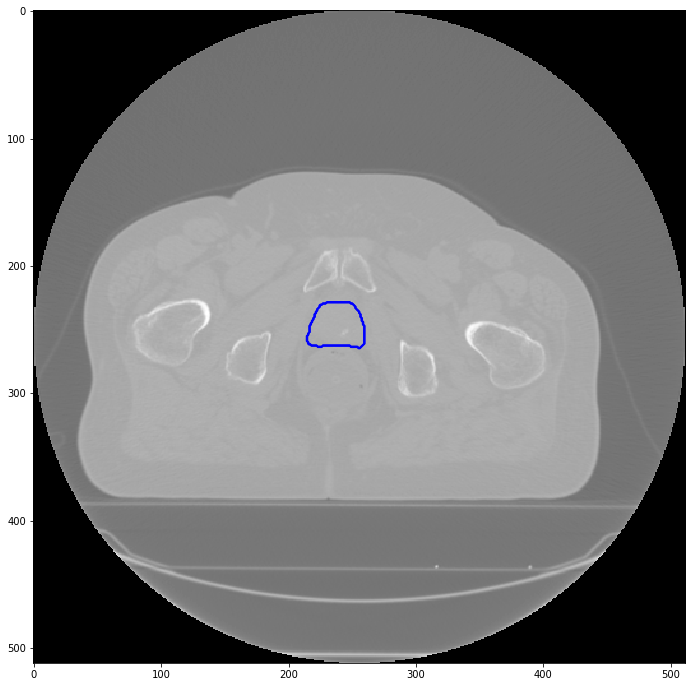

In [8]:
target_img = image[..., 20]
target_label = label[..., 20]
print(np.unique(target_label))
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(target_img, cmap="gray")
plt.contour(target_label, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors=colors)
plt.show()

In [9]:
def make_surface_contour(mask):
    interior = morphology.erosion(mask,np.ones([3,3])) # one last dilation 
    contour = np.where(interior==0, 1, 0)
    surface = contour*mask
    return surface, interior

In [61]:
def search(vector, r, i, pos_neighbor, neg_neighbor, pos_current_distance, neg_current_distance):
    if vector[i] != 0:   
        if i-r > 0:
            if i-r < min(pos_current_distance):
                pos_current_distance.append(i-r)
                #pos_neighbor = vector[i]
                pos_neighbor = i
            
        elif i-r < 0:
            if abs(i-r) < min(neg_current_distance):
                neg_current_distance.append(abs(i-r))
                #neg_neighbor = vector[i]
                neg_neighbor = i
    return pos_neighbor, neg_neighbor

def nearest_neighbor_search(vector, r):
    pos_neighbor = 0
    neg_neighbor = 0
    pos_current_distance = [len(vector)]
    neg_current_distance = [len(vector)]
    for i in range(0, len(vector)-1):
        pos_neighbor, neg_neighbor = search(vector, r, i, pos_neighbor, neg_neighbor, pos_current_distance, neg_current_distance)
    return pos_neighbor, neg_neighbor

In [62]:
import random
import math
  
def order_voxel_list(start, surface_cord):
    x_surface = surface_cord[..., 0] 
    y_surface = surface_cord[..., 1]
    locations  = ((x_surface - start[0])**2)**0.5 + ((y_surface - start[1])**2)**0.5
    data = pd.DataFrame() 
    data["x"] = surface_cord[..., 0]
    data["y"] = surface_cord[..., 1]
    data["location"] = np.array(locations)
    data = data.sort_values(by = "location")
    #list of L
    L = list(zip(data["x"], data["y"]))
    L = [list(i) for i in L]
    #list of Fct based on L
    Fct_L = []
    for l in range(data.shape[0]):
        Fct_L.append(list(find_Fct(target_img, data["x"][l], data["y"][l], a, voxelsize, dist)))
    Fct_L = np.array(Fct_L)
    return L, Fct_L

def find_pd(i, start, surface_cord, circles):
    L, Fct_L = order_voxel_list(start, surface_cord)
    R = len(L)
    phi_q = uniform.rvs(0, 2*np.pi, size = 1)
    mq = circles
    pq = np.sin(2*np.pi*(i/R)*mq + phi_q)
    #pq_y = np.sin(2*np.pi*(i/Q)*mq + phi_q)
    return pq, L, Fct_L

In [63]:
## Smoothing alg:
def search_nearest_from_L(r, i, L, k):
    i = L.index([r, i])
    if i-k >= 0 and i+k+1 <= len(L):
        K = list(range(i-k, i+k+1))
        #K_list = L[i-k : i+k+1]
    elif i-k < 0 and i+k+1 <= len(L):
        K = list(range((i + len(L) - k), len(L))) + list(range(0, i+k+1))    #K_list = L[0 : i+k+1]
    elif i-k >= 0 and i+k+1 > len(L):
        K = list(range(i-k, len(L))) + list(range(0, (i + k - len(L)) + 1))
    elif i-k <0 and i+k+1 > len(L):
        K = range(0, len(L))
        #K_list = L[i-1, len(L)]
    return K

def smooth_Fct(roi, r, i, L, Fct_L, a, voxelsize, dist, k):
    K = search_nearest_from_L(r, i, L, k)
    K_after = np.array(K) % len(L)
    K_after = K_after[K_after > 0]
    Fct_r = find_Fct(roi, r, i, a, voxelsize, dist)
    Fct_k = np.array([Fct_L[k] for k in K_after])
    '''
    Fct_k = []
    for k in K_after:
        Fct_k.append(list(find_Fct(roi, L[k][0], L[k][1], a, voxelsize, dist))) 
    Fct_k = np.array(Fct_k)
    '''
    #Find_ct = lambda t: find_Fct(roi, L[t][0], L[t][1], a, voxelsize, dist)
    #Find_ct = lambda t: print([L[t][0], L[t][1]])
    #Fct_k = np.array([Find_ct(ki) for ki in K])
    Fct_x = 1/(2*k+1)*(Fct_r[0] + sum(Fct_k[..., 0]))
    Fct_y = 1/(2*k+1)*(Fct_r[1] + sum(Fct_k[..., 1]))
    Fct_z = 1/(2*k+1)*(Fct_r[2] + sum(Fct_k[..., 2]))
    Fct_r = np.array([float(Fct_x), float(Fct_y), float(Fct_z)])
    return Fct_r

In [64]:
def find_Fsd(): 
    pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_x=norm.ppf(pRand_k, loc=0, scale=SD[0])
    pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_y=norm.ppf(pRand_k, loc=0, scale=SD[1])
    pRand_k = uniform.rvs(0, 1, size = 1)
    Fsd_z=norm.ppf(pRand_k, loc=0, scale=SD[2])
    Fsd_r = np.array([float(Fsd_x), float(Fsd_y), float(Fsd_z)])
    return Fsd_r

def find_Fct(roi, r, i, a, voxelsize, dist):
    gradct = (roi[r+1,i]-roi[r-1, i])/(dist*voxelsize)
    gradct_x = gradct[0]
    gradct_y = gradct[1]
    gradct_z = gradct[2]
    Fct_x = a/(np.abs(gradct_x)+a) #*np.copysign(1,  gradct_x)
    Fct_y = a/(np.abs(gradct_y)+a) #*np.copysign(1,  gradct_y)
    Fct_z = a/(np.abs(gradct_z)+a) #*np.copysign(1,  gradct_z)
    Fct_r = np.array([float(Fct_x), float(Fct_y), float(Fct_z)])
    return Fct_r
        
def find_Fct_interior_voxel(neg_Fct_r, pos_Fct_r, pos_r, neg_r, r, voxelsize):
    Fct_x = neg_Fct_r[0] + (pos_Fct_r[0] - neg_Fct_r[0])/((pos_r - neg_r)*voxelsize[0])*((r - neg_r)*voxelsize[0])
    Fct_y = neg_Fct_r[1] + (pos_Fct_r[1] - neg_Fct_r[1])/((pos_r - neg_r)*voxelsize[1])*((r - neg_r)*voxelsize[1])
    Fct_z = neg_Fct_r[2] + (pos_Fct_r[2] - neg_Fct_r[2])/((pos_r - neg_r)*voxelsize[2])*((r - neg_r)*voxelsize[2])
    Fct_r = np.array([float(Fct_x), float(Fct_y), float(Fct_z)])
    return Fct_r

def find_D(Fsd_r, Fct_r):
    Fct_x =  Fct_r[0]
    Fct_y =  Fct_r[1]
    Fct_z =  Fct_r[2]
    Fsd_x =  Fsd_r[0]
    Fsd_y =  Fsd_r[1]
    Fsd_z =  Fsd_r[2]
    D_x = Fsd_x*Fct_x
    D_y = Fsd_y*Fct_y
    D_z = Fsd_z*Fct_z
    D_r = [float(D_x), float(D_y), float(D_z)]
    return D_r

def r_to_xyz(F):
    F_x =  F[0]
    F_y =  F[1]
    F_z =  F[2]
    return F_x, F_y, F_z

In [119]:
def assd(slices, target_label, voxelsize, a, dist, SD, circles, k, smooth=True):
    row_size = target_label.shape[0]
    col_size = target_label.shape[1]
    mask = np.where(target_label!=0,4,0)
    surface, interior = make_surface_contour(mask)
    roi=slices*mask
    dim=roi.shape[0]
    mat = np.ndarray([dim, dim],dtype=np.float64)
    dx = np.zeros((512, 512))
    dy = np.zeros((512, 512))
    dz = np.zeros((512, 512))
    surface_cord = np.argwhere(surface != 0)
    start = random.choice(surface_cord.tolist())
    j = 0
    #pq, L, Fct_L = find_pd(j, start, surface_cord, circles)
    for i in range(0,dim-1):
        for r in range(0,dim-1):             
            if  surface[r, i] != 0:
                Fsd_r = find_Fsd()
                pq, L, Fct_L = find_pd(j, start, surface_cord, circles)
                if (smooth):
                    Fct_r = smooth_Fct(target_img, r, i, L, Fct_L, a, voxelsize, dist, k)
                else:
                    Fct_r = find_Fct(target_img, r, i, a, voxelsize, dist)
                D_r = find_D(Fsd_r, Fct_r)
                D_x, D_y, D_z = r_to_xyz(D_r)
                dx[r, i] = D_x*pq
                dy[r, i] = D_y*pq    
                j += 1
            
            elif interior[r, i] != 0: #roi[r, i] != 0
                pos_r, neg_r = nearest_neighbor_search(surface[r], i)
                if pos_r > neg_r:
                    '''
                    Fsd_r =  find_Fsd()
                    pos_Fct_r = find_Fct(target_img, pos_r, i, a, voxelsize, dist)
                    neg_Fct_r = find_Fct(target_img, neg_r, i, a, voxelsize, dist)
                    pos_Fct_x, pos_Fct_y, pos_Fct_z = r_to_xyz(pos_Fct_r)
                    neg_Fct_x, neg_Fct_y, neg_Fct_z = r_to_xyz(neg_Fct_r)
                    Fct_r = find_Fct_interior_voxel(neg_Fct_r, pos_Fct_r, pos_r, neg_r, r, voxelsize)
                    D_r = find_D(Fsd_r, Fct_r)
                    D.append(D_r)
                    D_x, D_y, D_z = r_to_xyz(D_r)
                    '''
                    dx[r, i] = 0.000000000000001 #D_x
                    dy[r, i] = 0.000000000000001 #D_y
            
    return dx, dy, mask

In [120]:
import cv2
def plotting_assd(dx, dy, mask, quiver=False, plot=True, display=False):
    roi_cord = np.argwhere(mask != 0)
    x = []
    y = []
    
    for i in roi_cord.tolist():
        x.append(i[0])
        y.append(i[1])
    x = np.array(x)
    y = np.array(y)
   
    u = []
    v = []
    w = []
    u_cord = np.argwhere(dx != 0)
    v_cord = np.argwhere(dy != 0)
    
    for i in u_cord.tolist():
        u.append(dx[i[0], i[1]])
    for i in v_cord.tolist():
        v.append(dy[i[0], i[1]])
    
    u = np.array(u)
    v = np.array(v)
          
          
    if (quiver): #False by default
        fig,ax = plt.subplots()
        ax.quiver(x, y, u, v)
        plt.show()
        
    DU_mask = np.zeros((512,512))
    x_new = x + v
    y_new = y + u
    for i in range(len(x_new)-1):
        DU_mask[int(round(x_new[i], 0)), int(round(y_new[i], 0))] = 1
        #DU_mask[int(x[i]), int(y[i])] = 1
        
    du = make_mask(DU_mask, display)
    if (plot):
        fig,ax = plt.subplots(1,1,figsize=[12,12])
        #plt.imshow(target_img)
        plt.imshow(target_img)
        ax.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
        ax.contour(du, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
        plt.show()
        
    return du, x_new, y_new

In [121]:
#Standardize the pixel values
def make_mask(img, display):
    threshold = np.mean(img)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([8,8]))
    dilation = morphology.dilation(eroded,np.ones([10,10]))

    #labels = measure.label(dilation) # Different labels are displayed in different colors
    blur = cv2.GaussianBlur(dilation,(5,5),0)
    
    if (display):
        fig, ax = plt.subplots(2, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("Smoothing noise using Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Mask")
        ax[1, 1].imshow(blur, cmap='gray')
        ax[1, 1].axis('off')
        
        plt.show()
    return blur

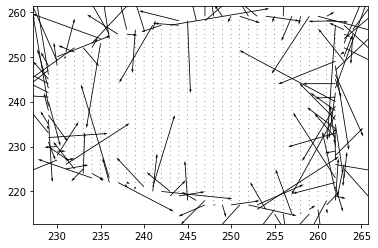

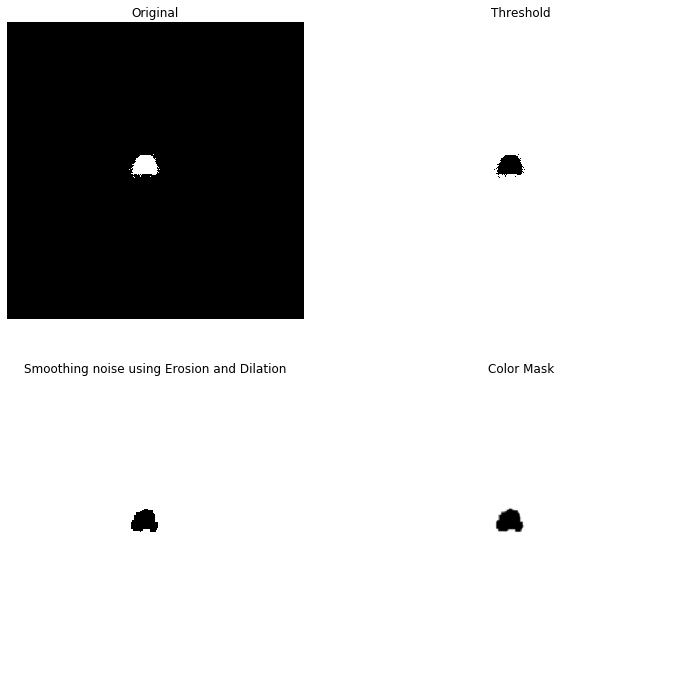

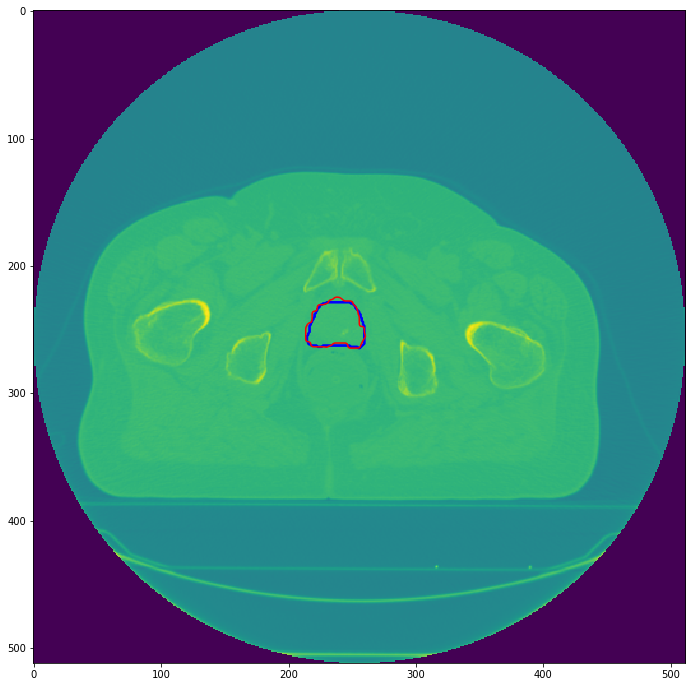

In [126]:
# roi = target_label*target_img
a=50
dist=2
#voxelsize = np.array([0.488281, 0.488281, 1.25])
voxelsize = np.array([0.976562, 0.976562, 2.5])
c = 3
SD=[c*1.7, c*2, c*2.5]
dx, dy, mask  = assd(target_img, target_label, voxelsize, a, dist, SD, circles=3, k=50, smooth=True)
du, x_new, y_new = plotting_assd(dx, dy, mask, quiver=True, plot=True, display=True)

(-0.5, 511.5, 511.5, -0.5)

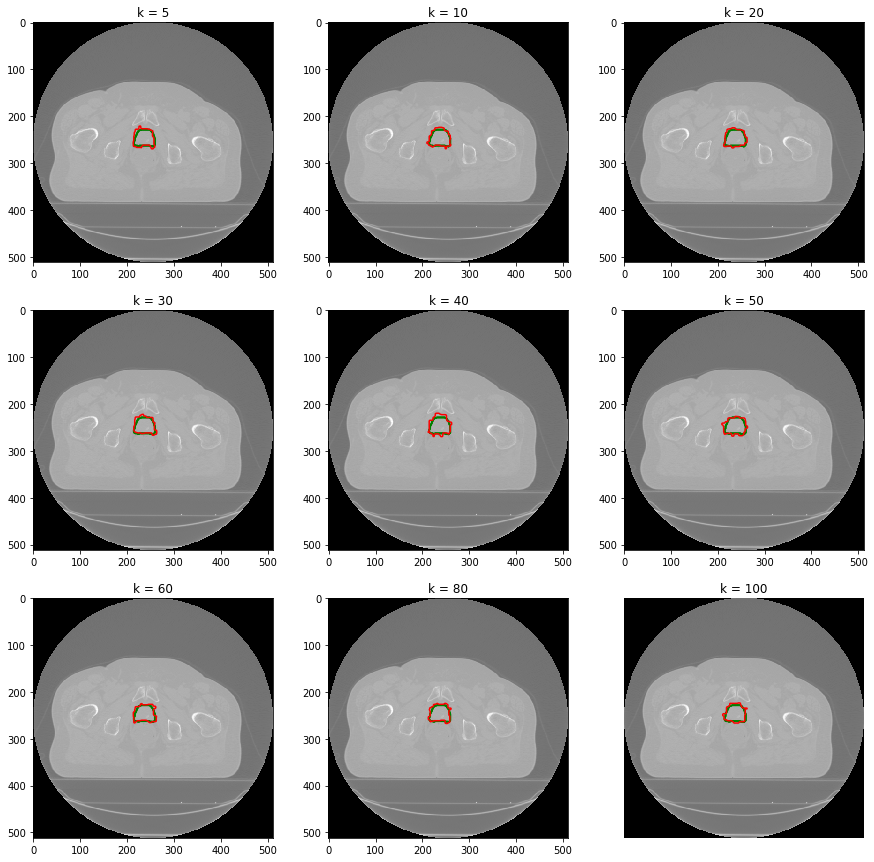

In [96]:
plt.figure(figsize=(15, 15))
K = [5, 10, 20, 30, 40, 50, 60, 80, 100]
        
for i in range(len(K)):
    c = 4
    SD=[c*1.7, c*2, c*2.5]
    dx, dy, mask  = assd(target_img, target_label, voxelsize, a, dist, SD, circles=3, k=K[i], smooth=True)
    du = plotting_assd(dx, dy, mask, quiver=False, plot=False)
    plt.subplot(3, 3, i + 1)
    plt.imshow(target_img, cmap="gray")
    #plt.title("k = " + str(K[i]))
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du[0], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.title("k = " + str(K[i]))
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

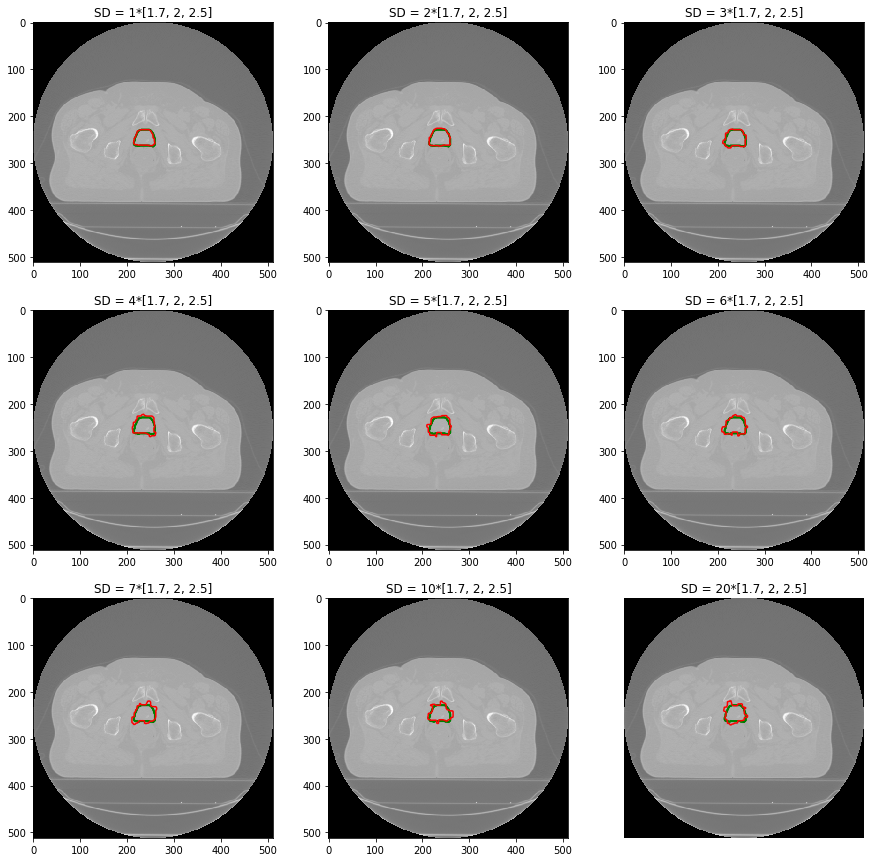

In [97]:
plt.figure(figsize=(15, 15))
c = [1, 2, 3, 4, 5, 6, 7, 10, 20]
        
for i in range(len(c)):
    SD=[c[i]*1.7, c[i]*2, c[i]*2.5]
    dx, dy, mask  = assd(target_img, target_label, voxelsize, a, dist, SD, circles=3, k=50, smooth=True)
    du = plotting_assd(dx, dy, mask, quiver=False, plot=False)
    plt.subplot(3, 3, i + 1)
    plt.imshow(target_img, cmap="gray")
    plt.contour(mask, levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="green")
    plt.contour(du[0], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.title("SD = " + str(c[i]) + "*[1.7, 2, 2.5]")
plt.axis('off')

## Testing code: